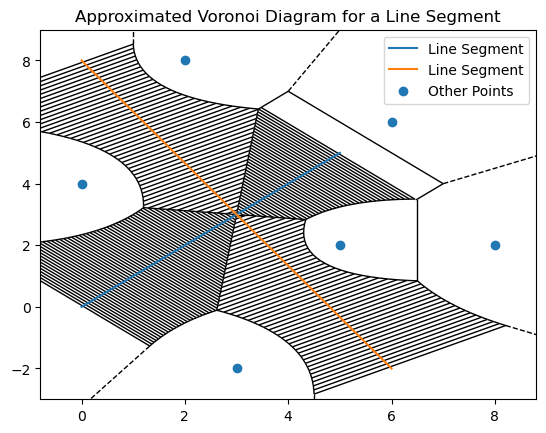

In [50]:
# Scipy approximation for voronoi diagram of line segment
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt

# Define the start and end points of the line segment
p1 = np.array([0, 0])
p2 = np.array([5, 5])
p3 = np.array([0, 8])
p4 = np.array([6, -2])



# Generate points along the line segment
num_points = 100  # Adjust for desired accuracy
line_points = np.array([p1 + (p2 - p1) * t for t in np.linspace(0, 1, num_points)])
line_points2 = np.array([p3 + (p4 - p3) * t for t in np.linspace(0, 1, num_points)])

# Add some other "seed" points to see the effect of the segment
other_points = np.array([[2, 8], [8, 2], [3, -2], [0, 4], [6, 6], [5, 2]])
all_points = np.vstack((line_points, line_points2, other_points))

# Compute the Voronoi diagram
vor = Voronoi(all_points)

# Plot the Voronoi diagram
fig = voronoi_plot_2d(vor, show_points=False, show_vertices=False)
plt.plot(line_points[:, 0], line_points[:, 1], label='Line Segment')
plt.plot(line_points2[:, 0], line_points2[:, 1], label='Line Segment')
plt.scatter(other_points[:, 0], other_points[:, 1], label='Other Points')
plt.legend()
plt.title('Approximated Voronoi Diagram for a Line Segment')
plt.show()


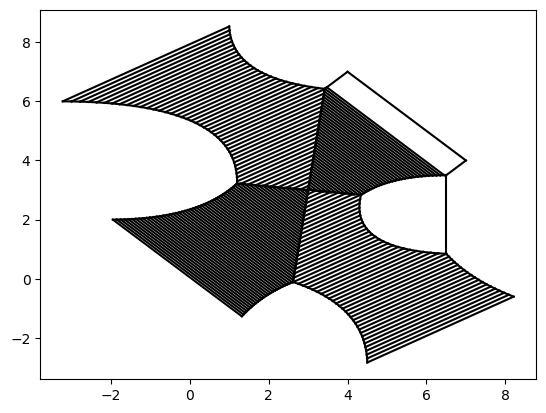

In [ ]:
from matplotlib.collections import LineCollection
# TODO: extract only boundary lines from line collection

ax = fig.axes[0]
segments = ax.collections[0].get_segments()
for seg in segments:
    ((x0, y0), (x1, y1)) = seg
    plt.plot([x0, x1], [y0, y1], color="k")

[1]
xi:-6, xf:-10, yi:-6, yf:-10
xi:6, xf:10, yi:6, yf:10


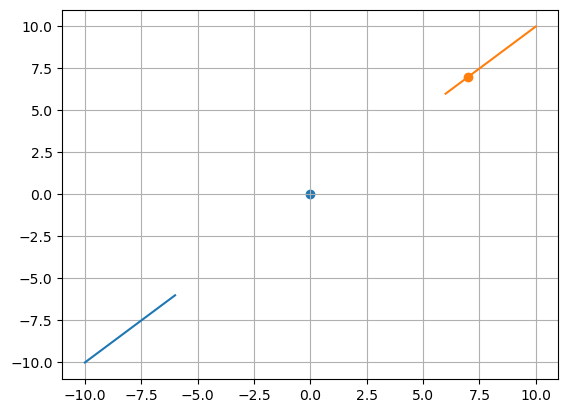

In [16]:
# pyvoronoi version of voronoi diagram of line segment
import pyvoronoi
pv = pyvoronoi.Pyvoronoi(1)

segs = [
    # xi, yi    xf, yf
    [[-6, -6], [-10, -10]], 
    [[6, 6], [10, 10]]
        ]

pts = [
    [0, 0],
    [7, 7]
    ]



# Those two segments do not intersect or overlap anything
pv.AddSegment(segs[0])
pv.AddSegment(segs[1])

# The second point is located on the second segment
pv.AddPoint(pts[0])
pv.AddPoint(pts[1])

pv.Construct()
# Will return [1] as the second point is on the second segment
invalid_points = pv.GetPointsOnSegments()
print(invalid_points)


for seg in segs:
    print(f"xi:{seg[0][0]}, xf:{seg[1][0]}, yi:{seg[0][1]}, yf:{seg[1][1]}")
    plt.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]])


for pt in pts:
    plt.scatter(pt[0], pt[1])

plt.grid()

# [seg["U0"].iloc[j], seg["V0"].iloc[j]], [seg["U1"].iloc[j], seg["V1"].iloc[j]]

[0.3, 0.75, 0.25] [0.25, 0.5, 1]
vertex 0 is located at (0.5, 0.5)
edge 0 starts at 0 and ends at -1 
edge 1 starts at -1 and ends at 0 
edge 2 starts at -1 and ends at 0 
edge 3 starts at 0 and ends at -1 
edge 4 starts at -1 and ends at 0 
edge 5 starts at 0 and ends at -1 
0 [2, 0] [-1, 0, -1] 0
1 [5, 1] [0, -1, 0] 2
2 [4, 3] [-1, 0, -1] 1


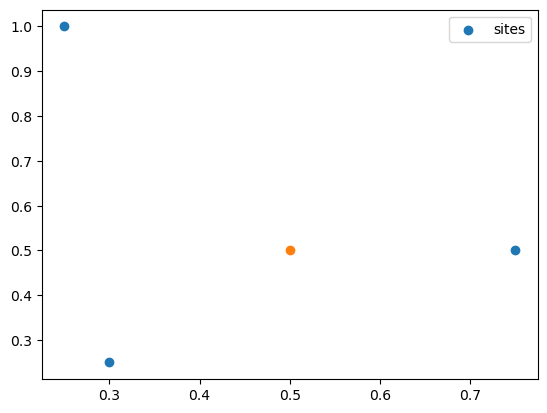

In [ ]:
import pyvoronoi
import matplotlib.pyplot as plt

# -----------------------------
# 1. Build Voronoi diagram
# -----------------------------
pv = pyvoronoi.Pyvoronoi()

points = [
    [0.30, 0.25],
    [0.75, 0.5],
    [0.25, 1]
]

x = [p[0] for p in points]
y = [p[1] for p in points]
for p in points:
    pv.AddPoint(p)

pv.Construct()

# -----------------------------
# 2. Plot
# -----------------------------
plt.subplot(111)
print(x, y)
plt.scatter(x, y, label="sites")

# Plot voronoi vertex
for index, vertex in pv.EnumerateVertices():
    print(f"vertex {index} is located at {vertex.X, vertex.Y}")
    plt.scatter(vertex.X, vertex.Y)

for index, edge in pv.EnumerateEdges():
    print(f"edge {index} starts at {edge.start} and ends at {edge.end}")


for index, cell in pv.EnumerateCells():
    print(index, cell.edges, cell.vertices, cell.site)
plt.legend()
plt.show()